In [53]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer  # to fill missing values with imputation e.g. median

from sklearn.model_selection import train_test_split  # random split
from sklearn.model_selection import StratifiedShuffleSplit  # random but proportionate split
from sklearn.model_selection import cross_val_score  # k-fold cross validation
from sklearn.model_selection import GridSearchCV  # autosearch for best hyperparameters for fitting

from sklearn.preprocessing import OrdinalEncoder  # encode 0,1,2,3,... for categorical 
from sklearn.preprocessing import OneHotEncoder  # get dummy 0 & 1 vector for categorical
from sklearn.preprocessing import StandardScaler  # scale against mean & standard deviation
from sklearn.preprocessing import MinMaxScaler  # normalisation to between 0 & 1
from sklearn.base import BaseEstimator, TransformerMixin  # for user-defined fit transformers
from sklearn.pipeline import Pipeline  # for sequences of transformations
from sklearn.compose import ColumnTransformer  # apply different transformers to different columns in same df

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error


In [2]:
housing = pd.read_csv('housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

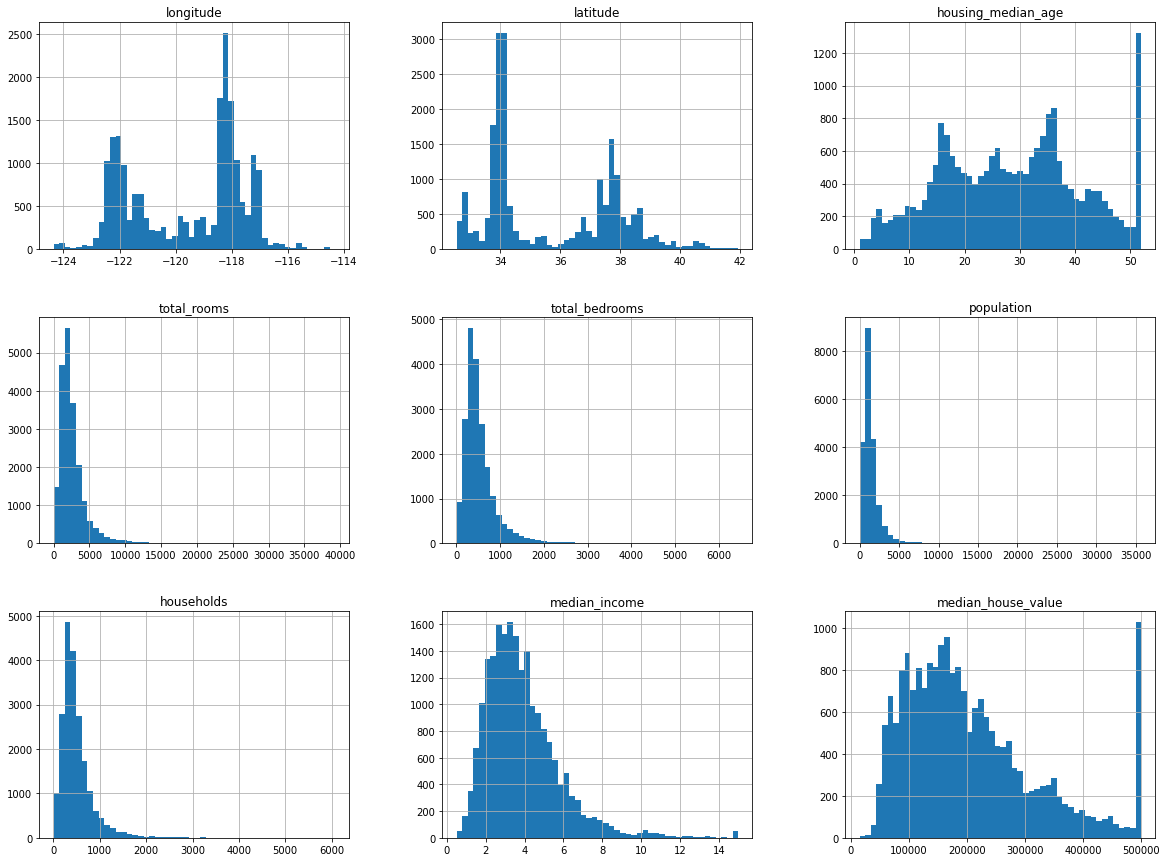

In [5]:
housing.hist(bins=50, figsize=(20,15));

In [6]:
# np.random.seed(1)
np.random.permutation(10)

array([7, 4, 8, 0, 9, 2, 3, 6, 1, 5])

In [7]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

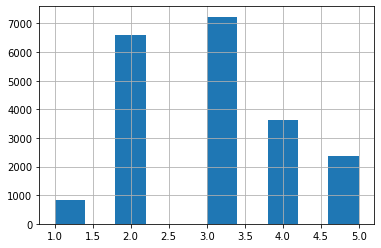

In [8]:
bin_edges = [0., 1.5, 3., 4.5, 6., np.inf]
labels = [1, 2, 3, 4, 5]
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=bin_edges, 
                               labels=labels)
housing['income_cat'].hist();

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # 1 shuffle so 1 test with .8/.2 split
# n_splits: number of re-shuffling & splitting iterations
for train_index, test_index in split.split(X=housing, y=housing['income_cat']):
    # Stratification is done based on the y labels
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

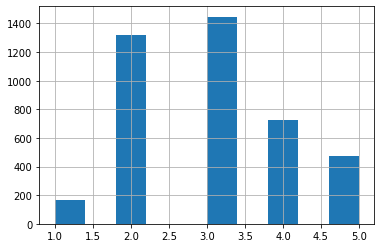

In [10]:
strat_test_set['income_cat'].hist();  # same proportions as from the whole dataset

In [11]:
# 5 iterations?
split5 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)  # 5 split runs, all with .8/.2 split
for train_index5, test_index5 in split5.split(X=housing, y=housing['income_cat']):
    # Stratification is done based on the y labels
    strat_train_set5 = housing.loc[train_index5]
    strat_test_set5 = housing.loc[test_index5]
    print(len(strat_test_set5))

4128
4128
4128
4128
4128


In [12]:
# leave the test set alone 
housing = strat_train_set.copy()

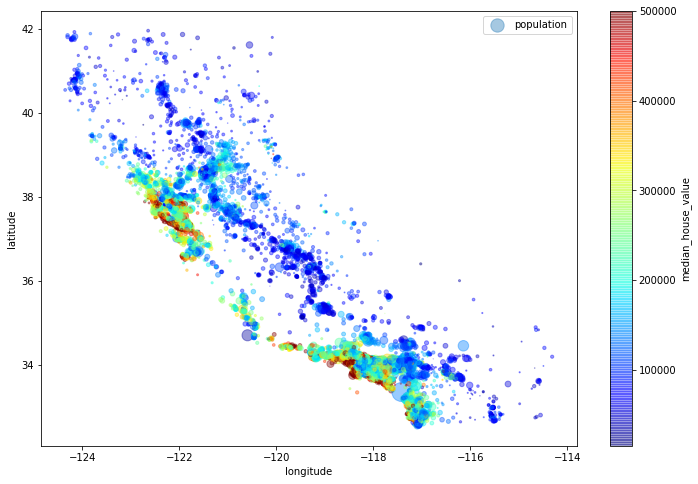

In [13]:
# multivariate geographical plot
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.4,
             s=housing['population']/100, label='population', figsize=(12,8), 
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False)
plt.legend();

plt.savefig("housing_prices_scatterplot")  # this is California

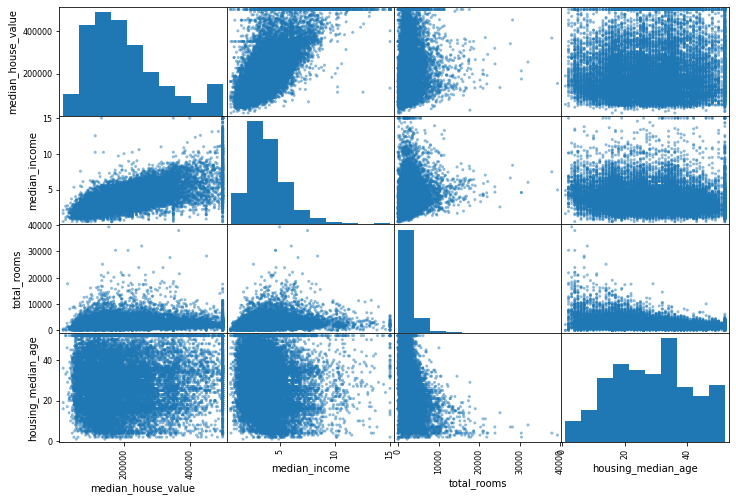

In [14]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3


In [16]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)  # drop labels for training set

In [17]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
income_cat              0
dtype: int64

In [18]:
# fill NaN with imputer function
imputer = SimpleImputer(strategy='median')
# remove the text attribute because median can only be calculated on numerical attributes
housing_numerical = housing.drop('ocean_proximity', axis=1)
# input is a df
X = imputer.fit_transform(housing_numerical)
# output is an array!
X  
# missing values have now been filled with medians

array([[-121.89  ,   37.29  ,   38.    , ...,  339.    ,    2.7042,
           2.    ],
       [-121.93  ,   37.05  ,   14.    , ...,  113.    ,    6.4214,
           5.    ],
       [-117.2   ,   32.77  ,   31.    , ...,  462.    ,    2.8621,
           2.    ],
       ...,
       [-116.4   ,   34.09  ,    9.    , ...,  765.    ,    3.2723,
           3.    ],
       [-118.01  ,   33.82  ,   31.    , ...,  356.    ,    4.0625,
           3.    ],
       [-122.45  ,   37.77  ,   52.    , ...,  639.    ,    3.575 ,
           3.    ]])

In [19]:
# put array X back to dataframe and check for NaN again
housing_tr = pd.DataFrame(X, columns=housing_numerical.columns, index=housing_numerical.index)
housing_tr.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
income_cat            0
dtype: int64

In [20]:
imputer.statistics_  # the median value for each attribute (column)

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [21]:
# double check
housing_numerical.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [22]:
pd.to_datetime('19/04/2021') + pd.DateOffset(28)

Timestamp('2021-05-17 00:00:00')

In [23]:
housing_cat = housing[['ocean_proximity']]  
# [[]] for 2D (dataframe) object to be compatible with fit_transform() next
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [24]:
# convert categories from text to numbers
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.]])

In [25]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
# alternatively, get 0's and a single 1 for each category, i.e. one-hot
onehot_encoder = OneHotEncoder()
housing_cat_1hot = onehot_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()  # 16512 rows, 5 categories from housing_cat column

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [27]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [28]:
# custom fit_transform class
rooms_ix, bedrooms_ix, popul_ix, households_ix = 3, 4, 5, 6  # column numbers

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # does nothing but introduces X
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]  # input X is array not df!
        popul_per_household = X[:, popul_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, popul_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, popul_per_household]

In [29]:
attr_adder = CombinedAttributesAdder()
housing_extra_attr = attr_adder.fit(housing.values)  # convert df to array with .values
housing_extra_attr  # returns "self"

CombinedAttributesAdder()

In [30]:
housing_extra_attr = attr_adder.fit_transform(housing.values)
housing_extra_attr[:5]  # returns transformed df

array([[-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
        '<1H OCEAN', 2, 4.625368731563422, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, 679.0, 108.0, 306.0, 113.0, 6.4214,
        '<1H OCEAN', 5, 6.008849557522124, 2.7079646017699117,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, 1952.0, 471.0, 936.0, 462.0, 2.8621,
        'NEAR OCEAN', 2, 4.225108225108225, 2.0259740259740258,
        0.24129098360655737],
       [-119.61, 36.31, 25.0, 1847.0, 371.0, 1460.0, 353.0, 1.8839,
        'INLAND', 2, 5.232294617563739, 4.135977337110481,
        0.20086626962642123],
       [-118.59, 34.23, 17.0, 6592.0, 1525.0, 4459.0, 1463.0, 3.0347,
        '<1H OCEAN', 3, 4.50580997949419, 3.047846889952153,
        0.23134101941747573]], dtype=object)

In [31]:
# to recover the column names and convert the output array to a df
housing_extra_attribs = pd.DataFrame(
    housing_extra_attr,
    columns=list(housing.columns)+["rph", "pph", "bpr"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rph,pph,bpr
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2,4.625369,2.094395,0.223852
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5,6.00885,2.707965,0.159057
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2,4.225108,2.025974,0.241291
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2,5.232295,4.135977,0.200866
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3,4.50581,3.047847,0.231341


In [32]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),  # fill missing values, outputs an array
                         ('attribs_adder', CombinedAttributesAdder()),  # compute additional attributes
                         ('std_scaler', StandardScaler())])  # scale all columns
housing_num_tr = num_pipeline.fit_transform(housing_numerical)  # input is df, output is array

# to recover the column names and convert the output array to a df
housing_num_tr = pd.DataFrame(
    housing_num_tr,
    columns=list(housing_numerical.columns)+["rph", "pph", "bpr"],
    index=housing.index)
housing_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rph,pph,bpr
17606,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.954456,-0.312055,-0.086499,0.155318
18632,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1.890305,0.217683,-0.033534,-0.836289
14650,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.954456,-0.465315,-0.092405,0.422200
3230,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.954456,-0.079661,0.089736,-0.196453
3555,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.006202,-0.357834,-0.004194,0.269928


In [33]:
num_attribs = list(housing_numerical)  # numerical columns
cat_attribs = ['ocean_proximity']      # categorical columns

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),  
                                   ('cat', OneHotEncoder(), cat_attribs)])
                                   # list of tuples (name, transformer, to_transform)
housing_full_tr = full_pipeline.fit_transform(housing)  # input is df, output is array

housing_full_tr[:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.95445595, -0.31205452,
        -0.08649871,  0.15531753,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  1.89030518,  0.21768338,
        -0.03353391, -0.83628902,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.95445595, -0.46531516,
        -0.09240499,  0.4222004 ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.95445595, -0.07966124,
         0.08973561, -0.19645314,  0.        ,  1.        ,  0.        ,
         0.        

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(housing_full_tr, housing_labels)  # fit(X, y)

LinearRegression()

In [35]:
housing_pred = lin_reg.predict(housing_full_tr)
lin_mse = mean_squared_error(housing_labels, housing_pred)  # metrics(y, y_hat)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459939

In [36]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_full_tr, housing_labels)

DecisionTreeRegressor()

In [37]:
housing_pred_tree = tree_reg.predict(housing_full_tr)
tree_mse = mean_squared_error(housing_labels, housing_pred_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [38]:
scores_tree = cross_val_score(tree_reg,
                              housing_full_tr,
                              housing_labels,
                              scoring='neg_mean_squared_error',  # negative scoring options
                              cv=10)  # 10-fold
tree_rmse_scores = np.sqrt(-scores_tree)
tree_rmse_scores

array([69547.82017227, 67327.10326239, 70522.96747532, 70560.50696291,
       71272.69915349, 75320.17785139, 71843.77919827, 70542.0479892 ,
       76158.51144778, 70966.8435043 ])

In [39]:
# valid scoring options in cross_val_score
import sklearn
np.array(sklearn.metrics.SCORERS.keys())

array(dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jacca

In [40]:
# cross validate the linear regression model now
scores_lin = cross_val_score(lin_reg,
                             housing_full_tr,
                             housing_labels,
                             scoring='neg_mean_squared_error',
                             cv=10)
np.sqrt(-scores_lin)

array([66877.52325028, 66608.120256  , 70575.91118868, 74179.94799352,
       67683.32205678, 71103.16843468, 64782.65896552, 67711.29940352,
       71080.40484136, 67687.6384546 ])

In [41]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_full_tr, housing_labels)

RandomForestRegressor()

In [42]:
scores_forest = cross_val_score(forest_reg,
                                housing_full_tr,
                                housing_labels,
                                scoring='neg_mean_squared_error',
                                cv=10)
np.sqrt(-scores_forest)

array([49518.48198536, 47179.38054717, 49751.68675861, 52030.23926078,
       49577.70635898, 53167.13603558, 49054.21637334, 48022.1303526 ,
       53190.06950373, 50049.55460572])

In [43]:
# use GridSearchCV to:
# try different combo of hyperparameters (grid search) and 
# run k-fold cross validation (CV)
param_grid = [{'n_estimators': [10, 30], 'max_features': [4, 6, 8]}, 
              {'n_estimators': [3, 10], 'max_features': [3, 4], 'bootstrap': [False]}]
              # parameter names in param_grid must match with those from the estimator 

# estimator:
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,   # estimator
                           param_grid,   # parameter search
                           cv=5, scoring='neg_mean_squared_error',  # cross validation
                           return_train_score=True)
grid_search.fit(housing_full_tr, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [4, 6, 8], 'n_estimators': [10, 30]},
                         {'bootstrap': [False], 'max_features': [3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [48]:
# scores from all combinations of input hyperparameters
cv_res = grid_search.cv_results_
list(zip(cv_res["mean_test_score"], cv_res["params"]))  # negative scores from scoring option in cv

[(-2877720685.2356157, {'max_features': 4, 'n_estimators': 10}),
 (-2642119983.0464106, {'max_features': 4, 'n_estimators': 30}),
 (-2812401381.380797, {'max_features': 6, 'n_estimators': 10}),
 (-2606460562.8976398, {'max_features': 6, 'n_estimators': 30}),
 (-2828172767.194745, {'max_features': 8, 'n_estimators': 10}),
 (-2570554953.1533546, {'max_features': 8, 'n_estimators': 30}),
 (-3655151955.2499275,
  {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}),
 (-2832021836.7443914,
  {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}),
 (-3544297236.817992,
  {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}),
 (-2798082857.604547,
  {'bootstrap': False, 'max_features': 4, 'n_estimators': 10})]

In [51]:
# importance scores for the attributes at the best paramater combo
attr_importances = grid_search.best_estimator_.feature_importances_

# get the attributes names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]  # added numerical columns
cat_encoder = full_pipeline.named_transformers_["cat"]  # to extract one-hot encoded column names
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# most important attributes in predicting median house price?
sorted(zip(attr_importances, attributes), reverse=True)

[(0.3260713129932691, 'median_income'),
 (0.1347589145618729, 'INLAND'),
 (0.13081057981564917, 'income_cat'),
 (0.11214298084280727, 'pop_per_hhold'),
 (0.06297091237733272, 'longitude'),
 (0.05571467810662003, 'latitude'),
 (0.045397781955286966, 'housing_median_age'),
 (0.032579300260236414, 'rooms_per_hhold'),
 (0.027257249372370243, 'bedrooms_per_room'),
 (0.016705309599977437, 'total_rooms'),
 (0.015598732887732988, 'households'),
 (0.01525937460273288, 'population'),
 (0.015232860248713596, 'total_bedrooms'),
 (0.004015640627902423, '<1H OCEAN'),
 (0.0032938952509306094, 'NEAR OCEAN'),
 (0.002118296109499875, 'NEAR BAY'),
 (7.218038706560978e-05, 'ISLAND')]

In [52]:
# now run the model on the test set
final_model = grid_search.best_estimator_  # use the best model from the validated training set

X_test = strat_test_set.drop('median_house_value', axis=1)  # attributes
y_test = strat_test_set['median_house_value'].copy()  # label

# apply the transformer pipeline
X_test_full_tr = full_pipeline.transform(X_test)

# apply the best estimator
y_test_pred = final_model.predict(X_test_full_tr)

# scoring
test_mse = mean_squared_error(y_test, y_test_pred)
np.sqrt(test_mse)

48439.402943028435

In [54]:
# compute a confidence interval for the mean of the squared errors (t statistic)
confidence = 0.95
squared_errors = (y_test_pred - y_test) ** 2
stat_squared_errors = stats.t.interval(confidence, 
                                       len(squared_errors) - 1,  # DoF
                                       loc=squared_errors.mean(),  # mean
                                       scale=stats.sem(squared_errors))  # standard error for the mean
# confidence interval for the rmse
np.sqrt(stat_squared_errors)  

array([46472.58397863, 50329.41936188])